### This notebook develops a regression tree algorithm based on PySWMM results following steps:

1. Split data into training and testing (70/30)
2. Hyperparamter tuning with 10-fold CV (on testing data)
3. Feature importance with 10-fold CV (on testing data)
4. Select features and apply to model 
5. Evaluate performance with 10-fold CV
    a. On testing data
    b. On training data 
6. Fit model on all of the data
7. Translate to ArcPy format for GIS tool
8. Check sensitivity to random seed
9. Sub-tree feature importance




In [1]:
import numpy as np  
import pandas as pd  
from pandas import *
import matplotlib.pyplot as plt 
import matplotlib.font_manager as font_manager
import seaborn as sns
%matplotlib inline

import sklearn as sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.tree import _tree

from operator import itemgetter
from sklearn import tree
from textwrap import wrap
import pickle

import sys,os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from os.path import dirname
parent_dir = (dirname(os.getcwd()))
sys.path.append("\\".join([parent_dir, 'model']) )

import functions
from functions import *


# Import files, set format

In [2]:
# Set the font properties   
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}
sub_plot = {'fontname':'Arial', 'size':'18','color':'black', 
            'weight':'bold','horizontalalignment':'left', 'verticalalignment':'center'}
font_path = 'C:\Windows\Fonts\Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)

In [3]:
#import core file
with open('out/CORE_ALL.pickle', 'rb') as handle:
    core = pickle.load(handle)
    core_df = pd.DataFrame(core)

In [4]:
#run processing function to turn initial soil conditions into categorical data
df = processing_nocat(core_df)
df=df[['fV','P_cm','A_hec','f_var','W_norm','ASM','Ks_mm','S']]

In [5]:
# initiate a pipeline
class PipelineRFE(Pipeline):
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self
    
# Sets RNG seed to reproduce results
_ = StratifiedKFold(random_state=42,shuffle=True)
pipeline = PipelineRFE([('reg', 
                         DecisionTreeRegressor(random_state = 42)),
                       ])

# 1: Split into training and testing

70/30 training testing split

In [6]:
# split into X and y datasets
feature_names = (df.drop(labels="f_var", axis=1).columns)
X_all = df[feature_names].values
y_all = pd.DataFrame(df['f_var']).values.ravel()
feature_labels={'fV':'$ɸ_P$',
                'P_cm':'$P$',
               'A_hec':'$A$',
                'W_norm':'$W$',
                'ASM':'$ASM$', 
                'Ks_mm':'Soil Texture',
               'S':'$S$'}
features_print = itemgetter(*feature_names)(feature_labels)

In [7]:
# #split into training and testing sets
X_all,y_all,X_train, X_test, y_train, y_test,feature_names=split(df)

# 2: hyperparameter tuning

- Create random grid

- Use the random grid to search for best hyperparameters

- Create the base model to tune

- Random search of parameters, using 10 fold cross validation

- Search across 100 different combinations, and use all available cores

- Scoring = use default model score (MSE)

- Returns best model hyperparameters

In [8]:
random_grid, max_depths, max_features, max_leaf_nodes, min_samples_splits,min_samples_leafs,splitters,presorts,min_impurity_decreases= hyper_grid()

best_params_all=dict()
cv_results_all=dict()
best_estimator_all=dict()
tree_random=()

_ = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
tree_random = RandomizedSearchCV(estimator = pipeline, param_distributions = random_grid, random_state=42,
                               n_iter = 500, cv = 10, verbose=0) 

#print(mse)
# Fit the random search model
tree_random.fit(X_train, y_train)
y_pred=tree_random.predict(X_test)

nrmse=np.sqrt(mean_squared_error(y_test, y_pred))/(np.max(y_test)-np.min(y_test))
score=r2_score(y_test,y_pred)

# print(nrmse)
# print(score)
# print(tree_random.best_params_)
best_reg=tree_random.best_estimator_
print(best_reg)


PipelineRFE(memory=None,
            steps=[('reg',
                    DecisionTreeRegressor(criterion='mse', max_depth=13,
                                          max_features='auto',
                                          max_leaf_nodes=110,
                                          min_impurity_decrease=0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=5,
                                          min_weight_fraction_leaf=0.0,
                                          presort=True, random_state=42,
                                          splitter='best'))],
            verbose=False)


### Plots
for visualization, plot hyperparameters and mse for training and testing sets


In [9]:
###### 
#sensitivity to max_depth
train_results_maxdepth = []
test_results_maxdepth = []
for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_maxdepth.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_maxdepth.append(mse)
    
    
#sensitivity to min_samples_split
train_results_split = []
test_results_split = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeRegressor(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_split.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_split.append(mse)
    
#sensitivity to max_features

train_results_features = []
test_results_features = []
for max_feature in max_features:
    dt = DecisionTreeRegressor(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_features.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_features.append(mse)
    
#sensitivity to max_leaf_nodes

train_results_nodes = []
test_results_nodes = []
for max_leaf_node in max_leaf_nodes:
    dt = DecisionTreeRegressor(max_leaf_nodes=int(max_leaf_node))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_nodes.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_nodes.append(mse)

train_results_imp = []
test_results_imp = []
for min_impurity_decrease in min_impurity_decreases:
    dt = DecisionTreeRegressor(min_impurity_decrease=int(min_impurity_decrease))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_imp.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_imp.append(mse)
    
train_results_samples = []
test_results_samples = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeRegressor(min_samples_leaf=int(min_samples_leaf))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_samples.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_samples.append(mse)

train_results_maxleafs = []
test_results_maxleafs = []
for max_leaf_node in max_leaf_nodes:
    dt = DecisionTreeRegressor(max_leaf_nodes=int(max_leaf_node))
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_maxleafs.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_maxleafs.append(mse)

train_results_splitters = []
test_results_splitters = []
for splitter in splitters:
    dt = DecisionTreeRegressor(splitter=splitter)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_splitters.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_splitters.append(mse)

train_results_presort = []
test_results_presort = []
for presort in presorts:
    dt = DecisionTreeRegressor(presort=presort)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    mse=mean_squared_error(y_train,train_pred)
        
    # Add auc score to previous train results
    train_results_presort.append(mse)
    y_pred = dt.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    # Add auc score to previous test results
    test_results_presort.append(mse)


Text(0.78, 0.4, 'H')

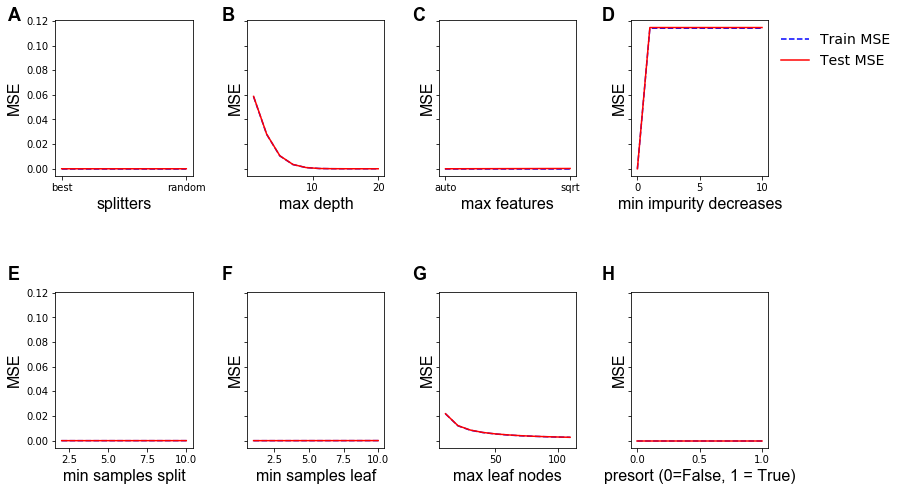

In [31]:
fig, axes = plt.subplots(2,4,figsize=(11,6),sharex=False, sharey=True)
fig.subplots_adjust(left=0.09, bottom=0.001, right=0.99, top=0.99, wspace=0.4)
plt.subplots_adjust(hspace = 0.75)
#from matplotlib.legend_handler import HandlerLine2D

axes[0,0].plot(splitters, train_results_splitters, 'b--', label= 'Train MSE')
axes[0,0].plot(splitters, test_results_splitters, 'r', label= 'Test MSE')
# axes[0,0].scatter(splitters, test_results_splitters, 'r', label= 'Test MSE')

axes[0,0].set_xlabel('splitters',**axis_font)

axes[0, 1].plot(max_depths, train_results_maxdepth, 'b--', label= 'Train MSE')
axes[0, 1].plot(max_depths, test_results_maxdepth, 'r', label= 'Test MSE')
axes[0, 1].set_xlabel('max depth',**axis_font)

axes[1,0].plot(min_samples_splits, train_results_split, 'b--', label= 'Train MSE')
axes[1,0].plot(min_samples_splits, test_results_split, 'r', label= 'Test MSE')
axes[1,0].set_xlabel('min samples split',**axis_font)

axes[1, 1].plot(min_samples_leafs, train_results_samples, 'b--', label= 'Train MSE')
axes[1, 1].plot(min_samples_leafs, test_results_samples, 'r', label= 'Test MSE')
axes[1, 1].set_xlabel('min samples leaf',**axis_font)

axes[0,2].plot(max_features, train_results_features, 'b--', label= 'Train MSE')
axes[0,2].plot(max_features, test_results_features, 'r', label= 'Test MSE')
axes[0,2].set_xlabel('max features',**axis_font)

axes[1,2].plot(max_leaf_nodes, train_results_nodes, 'b--', label= 'Train MSE')
axes[1,2].plot(max_leaf_nodes, test_results_nodes, 'r', label= 'Test MSE')
axes[1,2].set_xlabel('max leaf nodes',**axis_font)

axes[0,3].plot(min_impurity_decreases, train_results_imp, 'b--', label= 'Train MSE')
axes[0,3].plot(min_impurity_decreases, test_results_imp, 'r', label= 'Test MSE')
axes[0,3].set_xlabel('min impurity decreases',**axis_font)

axes[1,3].plot(presorts, train_results_presort, 'b--', label= 'Train MSE')
axes[1,3].plot(presorts, test_results_presort, 'r', label= 'Test MSE')
axes[1,3].set_xlabel('presort (0=False, 1 = True)',**axis_font)

axes[0,3].legend(['Train MSE','Test MSE'],bbox_to_anchor=(1,1),frameon=False,prop={'size': 14})

axe = axes.ravel()

for a in axe:
    a.set_ylabel("MSE",**axis_font)


fig.text(0.03, 1, "A",**sub_plot)
fig.text(0.3, 1,"B", **sub_plot)
fig.text(0.54, 1, "C",**sub_plot)
fig.text(0.78, 1, "D", **sub_plot)
fig.text(0.03, 0.4, "E", **sub_plot)
fig.text(0.3, 0.4, "F", **sub_plot)
fig.text(0.54, 0.4, "G", **sub_plot)
fig.text(0.78, 0.4, "H", **sub_plot)

**Figure A3. Sensitivity of regression tree hyperparameters. (A) Splitter method: MSE is relatively insensitive to splitter method (best or random). (B) Max depth: MSE decreases significantly as the max depth parameter increases, but at max depth greater than ~10, the MSE maintains a value of around 0. Thus, specifying a max depth much greater than 10 risks overfitting the dataset.  (C) Max features: MSE is relatively insensitive to the number of features to consider for each split. (D) Min impurity decrease: the minimum impurity decrease (or the maximum information gain) of a split tells the algorithm when to stop splitting a branch. A higher minimum impurity threshold (lower information gain) results in higher MSE.  (E) Min samples split: Increasing the values of min samples split risks under-fitting the data. When we require 100% of the data samples for a split, the MSE increases because the model cannot learn enough about the data.(F)  Min samples leaf: MSE increases as the minimum of samples at each leaf increases. This is because as min samples leaf increases, more of the variability is included at each leaf node. Allowing for more samples at each leaf risks under-fitting the data. (G) Max leaf nodes: similar to max depth, MSE decreases with increased leaf nodes. Thus, increasing the max number of leaf nodes has potential over-fit a model, however no absolute minimum MSE is achieved within this range.(H) Presort: MSE is insensitive to the presort parameter.**

# 3: feature importance

In [11]:
# compute feature importance of input features

mse_all,importance_all=feature_imp(X_train, y_train,features_print,best_reg)

mse_all=dict_to_df(mse_all,'all')
importance_all=pd.DataFrame.from_dict(importance_all)
importance_all=importance_all.stack().reset_index()

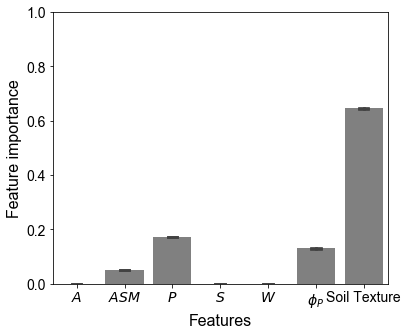

In [18]:
#plot feature importances

f, axes = plt.subplots(1,figsize= (6,5))
sns.barplot(y=0, x= "level_0", data=importance_all,  orient='v',
            color=("Grey"), capsize=.2)
axes.set_xlabel('Features',**axis_font)
axes.set_ylabel('Feature importance',**axis_font)
axes.set_ylim(0,1)
for label in (axes.get_xticklabels() + axes.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)  

plt.savefig("imp.pdf", transparent=True, bbox_inches='tight')


**Figure 7A. Feature importance metrics (panel A) were used to select important features for the final regression: ASM, P, ϕperv, and, soil texture.**

In [19]:
# Get numerical feature importances
importances = list(best_reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_print, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
imp_df=pd.DataFrame.from_dict(feature_importances)
imp_df=imp_df.rename(columns={0: "feature", 1: "importance"})
imp_df

,feature,importance
0,Soil Texture,0.65
1,$P$,0.17
2,$ɸ_P$,0.13
3,$ASM$,0.05


# 4: Select features

- select final features based on feature importance metrics
- extract X values for final features (X_all_select)

In [20]:
selected_features = ['fV','P_cm','ASM','Ks_mm']
X_all_select = df[selected_features].values
y_all = pd.DataFrame(df['f_var']).values.ravel()

features_print = itemgetter(*selected_features)(feature_labels)

#split X_all_select and y_all into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all_select, y_all, test_size=0.3, shuffle=True,random_state=42)
features_print

('$ɸ_P$', '$P$', '$ASM$', 'Soil Texture')

# 5: Cross validation accuracy 


###  5a: cross validation accuracy on training data

mean cv_mse = 0.0027007042240533123
mean cv_r2 = 0.9763209240401871
----------------


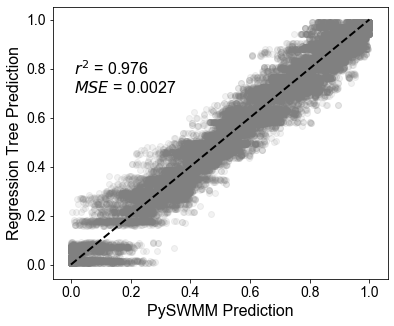

In [21]:
mse_all=dict()
scores_all=dict()
mse_all,scores_all=cv_10(X_train,y_train,best_reg)

f, ax = plt.subplots(1,figsize= (6,5))
plot_prediction(X_train, y_train,"","",ax,best_reg,mse_all,scores_all)
plt.savefig("reg.pdf", transparent=True, bbox_inches='tight')

**Figure 7B. The final regression tree predictions show excellent agreement with PySWMM predictions of ϕvar (panel B).  In panel B, dashed line represents a 1:1 relationship**

### 5b: cross validation accuracy on held out (testing) data

------------
testing mse = 0.0027414012983837314
testing r2 = 0.9760860743380539


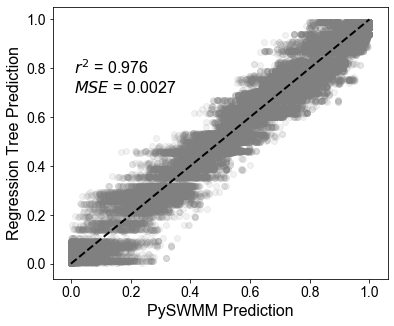

In [22]:
mse_testing,score_testing=testing_mse(X_train, X_test, y_train, y_test,best_reg)

f, ax = plt.subplots(1,figsize= (6,5))
plot_prediction(X_train, y_train,X_test,y_test,ax,best_reg,mse_all,scores_all)

# 6: Fit (train) regression on all data

In [23]:
best_reg.fit(X_all_select,y_all)
best_reg['reg']

#save as pickle file
filename = 'final_reg.sav'
pickle.dump(best_reg, open(filename, 'wb'))

# 7: Convert to ArcPy code

- Converts to ArcPy code for implementation in ArcGIS tool
- Copy and past resulting script into ArcPy, link to ArcGIS tool

In [24]:
# data_feature_names = ['fV', 'P_cm', 'ASM', 'Ks_mm','f_var']
# row[0] = fV
# row[1] = P
# row[2] = ASM
#row[3] = Ks
#row[4] = f_var

data_feature_names = ['row[0]', 'row[1]', 'row[2]', 'row[3]','row[4]']

tree_to_code(best_reg['reg'], list(data_feature_names));

for row in cursor:
    if (row[3] <= 4.949999928474426):
        if (row[1] <= 3.799999952316284):
            if (row[0] <= 0.2670476585626602):
                if (row[3] <= 0.800000011920929):
                    if (row[2] <= 1.5):
                        row[4]=0.98111494
                        cursor.updateRow(row)
                    elif (row[2] > 1.5):
                        if (row[0] <= 0.1364063322544098):
                            row[4]=0.90272083
                            cursor.updateRow(row)
                        elif (row[0] > 0.1364063322544098):
                            if (row[1] <= 2.0):
                                row[4]=0.71474074
                                cursor.updateRow(row)
                            elif (row[1] > 2.0):
                                row[4]=0.84122222
                                cursor.updateRow(row)
                elif (row[3] > 0.800000011920929):
                    if (row[0] <= 0.0955677404999733):
         

# 8: Check sensitivity to random state

[(0.9, 1.1), Text(0, 0.5, 'R2'), Text(0.5, 0, 'random seed')]

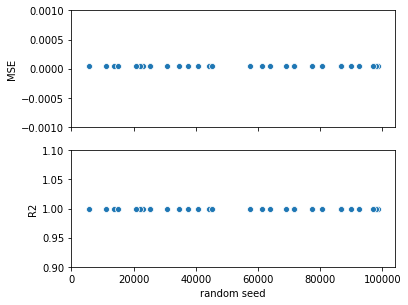

In [25]:
mse_all_rs=dict()
scores_all_rs=dict()

mse_all_rs,scores_all_rs=random_state(X_all_select,y_all)
mse_all_rs=dict_to_df(mse_all_rs,'all') #convert to df
scores_all_rs=dict_to_df(scores_all_rs,'all') #convert to df

# plot sensitivity to random state 

fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize= (5,4))
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.2)

sns.scatterplot(x='all', y="value", data=mse_all_rs,ax=ax1,
                palette=("Blues_d")).set(ylim=(-0.001, 0.001),xlabel='random seed',ylabel='MSE')  

sns.scatterplot(x="all", y="value", data=scores_all_rs,ax=ax2,
                palette=("Blues_d")).set(ylim=(0.9,1.1),xlabel='random seed',ylabel='R2')  

# 9: Feature importances - subsets

- check the MSE for each of the subtrees
- higher MSE for a subtree suggests that fvar varies more across this parameter

In [26]:
soils=[120.4, 0.3]
Ps= [1.5,10.2]
fVs= [0.2,0.8]
ASMs=[1,2,3]


for s,soil in enumerate(soils):
    print('/////////////////////')
    print('Ks_mm = ' + str(soil))
    dum=df.loc[df['Ks_mm'] ==soil]
    X = dum[selected_features].values 
    y = pd.DataFrame(dum['f_var']).values.ravel() 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30,shuffle=True, random_state=42) 
    
    mse_subset=dict()
    scores_all_subset=dict()
    mse,scores=testing_mse(X_train, X_test, y_train, y_test,best_reg)
    mse_subset.update({s:mse})
    
    importance_all=dict()
    mse_all=dict()
    mse_all,importance_all=feature_imp(X,y,features_print,best_reg)
    if s==0:
        sand_imp=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        sand_imp['scenario']='Sand ($K_s$ = 120.4 mm/hr)'
    if s==1:
        clay_imp=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        clay_imp['scenario']='Clay ($K_s$ = 0.3 mm/hr)'
        
importance_soil=pd.concat([clay_imp,sand_imp])

for p,pre in enumerate(Ps):
    print('/////////////////////')
    print('P = ' + str(pre))
    dum=df.loc[df['P_cm'] ==pre]
    X = dum[selected_features].values 
    y = pd.DataFrame(dum['f_var']).values.ravel() 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30,shuffle=True, random_state=42) 
    mse_subset=dict()
    scores_all_subset=dict()
    
    mse,scores=testing_mse(X_train, X_test, y_train, y_test,best_reg)
    mse_subset.update({s:mse})
    
    importance_all=dict()
    mse_all=dict()
    mse_all,importance_all=feature_imp(X,y,features_print,best_reg)
    if p==0:
        low_p=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        low_p['scenario']='P = 2.5 cm'
    if p==1:
        high_p=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        high_p['scenario']='P = 10.2 cm'
importance_p=pd.concat([low_p,high_p])
        

for f,veg in enumerate(fVs):
    print('/////////////////////')
    if f==0:
        print('fV <= ' + str(veg))
        dum=df.loc[df['fV'] < veg]
    else:
        print('fV >= ' + str(veg))
        dum=df.loc[df['fV'] > veg]    
    X = dum[selected_features].values 
    y = pd.DataFrame(dum['f_var']).values.ravel() 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30,shuffle=True, random_state=42) 
    mse_subset=dict()
    scores_all_subset=dict()
    mse,scores=testing_mse(X_train, X_test, y_train, y_test,best_reg)
    mse_subset.update({s:mse})
    
    importance_all=dict()
    mse_all=dict()
    mse_all,importance_all=feature_imp(X,y,features_print,best_reg)
    if f==0:
        low_veg=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        low_veg['scenario']='$ɸ_P$<0.2' 
    if f==1:
        high_veg=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        high_veg['scenario']='$ɸ_P$>0.8' 
importance_veg=pd.concat([low_veg,high_veg])

# mapping_asm = {'SAT': 1, 'FC': 2, 'WP':3}
for a,moist in enumerate(ASMs):
    print('/////////////////////')
    if moist==1:
        print('ASM = SAT')
    elif moist==2:
        print('ASM = FC')
    else:
        print('ASM = WP')
    dum=df.loc[df['ASM'] == moist]    
    X = dum[selected_features].values 
    y = pd.DataFrame(dum['f_var']).values.ravel() 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30,shuffle=True, random_state=42) 
    mse_subset=dict()
    scores_all_subset=dict()
    
    mse,scores=testing_mse(X_train, X_test, y_train, y_test,best_reg)
    mse_subset.update({s:mse})
    importance_all=dict()
    mse_all=dict()
    mse_all,importance_all=feature_imp(X,y,features_print,best_reg)
    if moist==1:
        high_moist=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        high_moist['scenario']='Saturated' 
    if moist==2:
        med_moist=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        med_moist['scenario']='Field Capacity' 
    if moist==3:
        low_moist=pd.DataFrame.from_dict(importance_all).stack().reset_index()
        low_moist['scenario']='Wilting Point' 

importance_asm=pd.concat([high_moist,med_moist,low_moist])


/////////////////////
Ks_mm = 120.4
------------
testing mse = 8.32328365998464e-05
testing r2 = 0.9950784065878049
/////////////////////
Ks_mm = 0.3
------------
testing mse = 6.930500005248815e-05
testing r2 = 0.9964953279457832
/////////////////////
P = 1.5
------------
testing mse = 0.0011748790360039663
testing r2 = 0.989243658576771
/////////////////////
P = 10.2
------------
testing mse = 0.00019140820674971973
testing r2 = 0.9975907262405787
/////////////////////
fV <= 0.2
------------
testing mse = 0.0010013338968722044
testing r2 = 0.985700922823803
/////////////////////
fV >= 0.8
------------
testing mse = 0.0007753358527857239
testing r2 = 0.9933702803491399
/////////////////////
ASM = SAT
------------
testing mse = 0.0009054087765253333
testing r2 = 0.9918240851025445
/////////////////////
ASM = FC
------------
testing mse = 0.0014748152776073767
testing r2 = 0.9867477179511046
/////////////////////
ASM = WP
------------
testing mse = 0.0015547460493601502
testing r2 = 0.9

### Plot for Figure 8. 

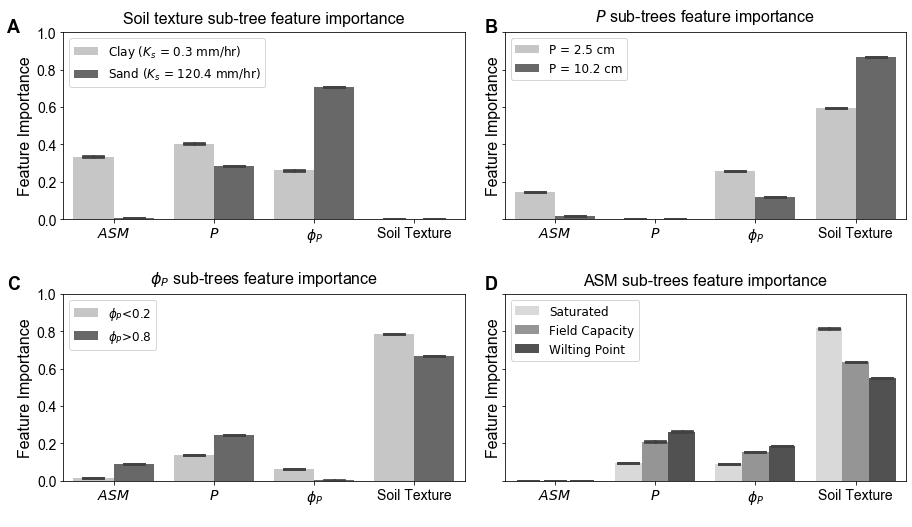

In [28]:
f, axes = plt.subplots(2,2,sharey=True,figsize= (13,7))
f.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.1)
plt.subplots_adjust(hspace = 0.4)
axe = axes.ravel()
sns.barplot(y=0, x= "level_0", data=importance_soil,  orient='v',
                palette="Greys",hue='scenario',capsize=.2,ax=axe[0])
sns.barplot(y=0, x= "level_0", data=importance_p,  orient='v',
            hue='scenario',palette="Greys",  capsize=.2,ax=axe[1])
sns.barplot(y=0, x= "level_0", data=importance_veg,  orient='v',
            hue='scenario',palette='Greys',  capsize=.2,ax=axe[2])
sns.barplot(y=0, x= "level_0", data=importance_asm,  orient='v',
            hue='scenario',palette='Greys', capsize=.2,ax=axe[3])  

axe[0].set_title('Soil texture sub-tree feature importance',**title_font)  
axe[1].set_title('$P$ sub-trees feature importance',**title_font)  
axe[2].set_title('$ɸ_P$ sub-trees feature importance',**title_font)  
axe[3].set_title('ASM sub-trees feature importance',**title_font)  

for a in axe:
    a.set_ylabel("Feature Importance",**axis_font)
    a.set_xlabel(" ")
    a.set_ylim(0,1)
    if a ==1 or a==3:
        a.set_ylabel("")

    a.legend(title = '', loc = 'upper left',prop={'size': 12})
    
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(14)  
        

f.text(0.03, 1, "A",  **sub_plot)
f.text(0.54, 1,"B",**sub_plot)
f.text(0.03, 0.49, "C",  **sub_plot)
f.text(0.54, 0.49, "D",  **sub_plot)

plt.savefig("subtrees.pdf", transparent=True, bbox_inches='tight')

**Figure 8. Feature importance across four predictor sub-trees. Soil texture sub-trees (clay and sand) illustrate a shift from precipitation (P) to pervious fraction (ϕperv) dominated connectivity with increasing permeability (panel A). ϕperv subtrees (< 0.2 and > 0.8) show increasing importance of soil texture at low ϕperv (panel B). Note that ϕperv importance in panel B is non-zero because ϕperv is ranges from 0-0.2 and 0.8-1 in the ϕperv sub-trees. P sub-trees (P = 2.5 cm, 10.2 cm) (panel C) and antecedent soil moisture (ASM) sub-trees (saturated and wilting point) show increasing importance of soil texture for high P value or increasing saturation.**